This notebook uses multiple predictors and a random forest model to predict peat depth across the Fens. The Google Earth Engine framework is used for processing and combining predictors. In the future, we will use the 'feature importance' from the random forest model to decide on which predictors to take forward for use in ML models. We will also export the train/test data (easiest as tabular) to PyTorch to compare the RF model against more complex machine learning algorithms. We can also use trained models to make peat depth predictions across the Fens. 


# Predictor List 

Currently implemented preditors:
1. Sentinel-2 with cloud removal (2 options): all bands 
2. NATMAP vector soil map


To be implemented: 
1. Rest of LandIS datasets 
2. Sentinel-2 relevant metrics such as NDVI or thermal-related
3. Sentinel-1 (SAR)
4. Landcover type (e.g. type of crops grown)
5. Lidar-derived metrics
6. Roddons (e.g. distance to)
7. Distance to watercourses/ditches
8. Geology
9. Any wastage features from Holman paper 

# Setup

In [1]:
# necessary imports 
import ee
import geemap
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# if error with geopandas then try running:
# pip install --upgrade --force-reinstall shapely

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# data and file paths
path_depths = "/Users/hamishcampbell/Documents/Cambridge/PhD/1st Year/Code/depth-mapping/Data/Ground Truth/depth_samples.shp" 
path_fenOutline = "/Users/hamishcampbell/Documents/Cambridge/PhD/1st Year/Code/depth-mapping/Data/CLR/NCA_46_The_Fens.shp"
path_vector = "projects/ee-depthmapping-hrac2/assets/Rasterised_NATMAPvector"
path_soilscapes = "projects/ee-depthmapping-hrac2/assets/Rasterised_NATMAPsoilscapes"
path_carbon = "projects/ee-depthmapping-hrac2/assets/Rasterised_NATMAPcarbon"
path_lidar = "projects/ee-depthmapping-hrac2/assets/test_lidar"

In [3]:
# initialise Google Earth Engine

# NOTE: first run only
#ee.Authenticate()

ee.Initialize()

In [4]:
# load the Fens outline shape file into GEE
fenOutline = ee.FeatureCollection(geemap.shp_to_ee(path_fenOutline))

# load the depth measurements shape file into GEE
depths = geemap.shp_to_ee(path_depths)

# Sentinel-2

## Cloud removal option 1 - "Mean Composite"

This cloud removal method finds all the non-cloudy pixels in the area of interest, within the time interval specified, and calculates the mean value of each pixel. The "CLD_PRB_THRESH" variable is used to specify what percentage of cloud is allowable before a pixel is labelled as cloudy (100 means nothing is labelled cloudy and so all pixels are used for mean calculation). The pixel cloudiness values are given by 's2cloudless' which is a seperate algorithm whose result can be obtained through GEE (provides a cloud probability value of 0-100).  

In [5]:
# cloud masking paramters to control aggression - values chosen to find best balance between cloud-removal and few
# NA data points
AOI = fenOutline
START_DATE = '2022-04-01'
END_DATE = '2022-07-01'
CLOUD_FILTER = 60                 # tiles with more than this percentage are removed from analysis
CLD_PRB_THRESH = 40               # pixels greater than this are considered clouds 
NIR_DRK_THRESH = 0.15             # used for cloud shadow detection
CLD_PRJ_DIST = 1
BUFFER = 50 

In [6]:
# Function to attach an s2cloudless tile to each of the sentinel tiles that denotes which pixels are likely to be clouds
def attach_cld_msk_to_sen(aoi, start_date, end_date):
    # Import and filter Sentinel-2 imagery
    s2_images = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless pixel values
    s2_cloudless = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the Sentinel collection by the 'system:index' (time) property
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_images,
        'secondary': s2_cloudless,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [7]:
# get Sentinel tiles with s2cloudless tiles attached
sentinel_with_s2cloudless = attach_cld_msk_to_sen(AOI, START_DATE, END_DATE)

In [8]:
# Function to add band with cloud mask information to Sentinel imagery
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


# Function to add band with cloud shadow mask information to Sentinel imagery
def add_shadow_bands(img):
    # Identify water pixels from the SCL band
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels)
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection)
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))


# Function to execute the addition of cloud and shadow bands to imagery and add combined mask
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


# Function to actually mask the images using the mask bands to remove clouds/shadows
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [9]:
# Apply all of the cloud/shadow mask functions to mask Sentinel imagery, and then calculate the mean composite image 
# from all the non-cloudy pixels at each point (mask determines which values get used in mean calculation)
sen_algorithm1 = (sentinel_with_s2cloudless.map(add_cld_shdw_mask)
                                           .map(apply_cld_shdw_mask)
                                           .mean())

## Cloud removal option 2 - "Prioritise Contiguous Tiles"

In [10]:
# get all surface reflectance Sentinel-2 imagery 
sen = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# select a start and end date for imagery composite to be made up of 
start_date = '2022-06-01'
end_date = '2022-07-01'

# keep only the data that meets some basic criteria
sen_filtered = (sen.filterBounds(fenOutline)
    .filterDate(start_date, end_date)               # temporally limited 
    .sort('CLOUD_COVERAGE_ASSESSMENT', False))      # sort tiles by cloud cover 

In [11]:
# Write a function that alters the pixel validity mask of a tile according to if cloud is present or not
def check_cloud_absence(tile): 
    # if MSK_CLDPRB less than 10 => low chance of cloud => let mask remain valid at that pixel
    # if medium-high chance of cloud (>10) => update mask to say pixel is invalid (mask = 0)
    return tile.updateMask(tile.select('MSK_CLDPRB').lte(10))

In [12]:
# obtain a (mostly) cloud-free mosaic for each quarter 
quarterly_mosaics = []
filter_start = ee.Date('2022-01-01')

for quarter in range(0,4):
    
    # keep only tiles from the quarter being studied
    quarterly_sen = sen_filtered.filterDate(filter_start, filter_start.advance(3,'month'))
    
    # Update the pixel validity mask to include condition on cloud absence
    quarterly_sen = quarterly_sen.map(check_cloud_absence)
        
    # stitch the most cloud-free tiles together and replace remaining cloud pixels with those from next tile with presence
    # NOTE: by sorting on cloud presence we keep complete image as temporally contiguous as possible
    quarterly_mosaic = quarterly_sen.mosaic()
    
    # store the results required
    quarterly_mosaics.append(quarterly_mosaic)
    
    # repeat for next quarter
    filter_start = filter_start.advance(3,'month')
    

In [13]:
# select the quarter of the year to use for modelling (1/2/3/4)
quarter = 2
sen_algorithm2 = quarterly_mosaics[quarter-1]

## Selection and Plotting

In [14]:
# select which of the cloud algorithms we want to use
sen = sen_algorithm1

In [15]:
# select all the useful Sentinel bands and rename them for interpretability
sen = sen.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'],
                  ['Blue', 'Green', 'Red', 'REdge1', 'REdge2', 'REdge3', 'NIR', 'REdge4', 'SWIR1', 'SWIR2'])

In [16]:
# plot the result (method 1 takes quite a while to render - zoom in and out to speed up)
Map = geemap.Map()
visParams = {
  'bands': ['Red', 'Green', 'Blue'],
  'max': 3000,
  'min': 0,
}
Map.centerObject(fenOutline, 8)
Map.addLayer(sen.clip(fenOutline), visParams, 'Sentinel 2')
Map

# plot the Fens outline in red
style = {
    'color': 'red',
    'fillColor': '00000000'
}
Map.centerObject(fenOutline, 8)
Map.addLayer(fenOutline.style(**style), {}, 'Fen Outline')

# plot the points at which ground-truth measurements were taken on the map in blue
style = {
    'color': 'blue',
    'pointSize': 2,
    'pointShape': 'circle'
}
Map.addLayer(depths.style(**style), {}, 'Depth Measurements')
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

## Sentinel Indices 

In [17]:
# https://eos.com/make-an-analysis/ndwi/
# calculate NDVI, used to highlight vegetation presence or greenness
ndvi = sen.normalizedDifference(['NIR', 'Red']).rename('NDVI')

# calculate NDWI, used to highlight waterbodies 
ndwi = sen.normalizedDifference(['Green', 'NIR']).rename('NDWI')

# calculate NDMI, used to highlight water content in plants
ndmi = sen.normalizedDifference(['NIR', 'SWIR1']).rename('NDMI')

In [18]:
Map = geemap.Map()
visParams = {
  'max': 1,
  'min': -1,
}
Map.centerObject(fenOutline, 8)
Map.addLayer(ndvi.clip(fenOutline), visParams, 'NDVI')
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

In [19]:
# add the indices to the other sentinel-2 predictors 
sen = sen.addBands([ndvi, ndwi, ndmi])

# NATMAP Predictors

## NATMAP Vector

In [20]:
# load the raster image from the GEE assets location (cannot load local raster files unlike with .shp files)
NATMAP_vector = ee.Image(path_vector)
NATMAP_vector = NATMAP_vector.rename(['Soiltype'])
NATMAP_vector = NATMAP_vector.cast({'Soiltype': 'uint16'})

In [21]:
# plot this categorical soil data on a new map
Map = geemap.Map()
visParams = {
    'min': 0,
    'max': 76,
}
Map.addLayer(NATMAP_vector.select('Soiltype'), visParams, 'Soil Map')
Map.centerObject(fenOutline, 8)
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

## NATMAP Soilscapes

In [22]:
# load the raster image 
NATMAP_soilscapes = ee.Image(path_soilscapes)
NATMAP_soilscapes = NATMAP_soilscapes.rename(['Soilscapes'])

In [23]:
# plot the soilscape data
Map = geemap.Map()
visParams = {
    'min': 0,
    'max': 20,
}
Map.addLayer(NATMAP_soilscapes, visParams, 'Soilscapes Map')
Map.centerObject(fenOutline, 8)
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

## NATMAP Carbon

In [24]:
# load the raster image (with 3 bands - 0 to 30, 30 to 100 and 100 to 150 carbon stock)
NATMAP_carbon = ee.Image(path_carbon)
NATMAP_carbon = NATMAP_carbon.rename(['AV_STK_150', 'AV_STK_30', 'AV_STK_100'])
NATMAP_carbon = NATMAP_carbon.clip(fenOutline)

In [25]:
# plot this carbon stock data 
Map = geemap.Map()
visParams = {
    'min': 0,
    'max': 86,
}
Map.addLayer(NATMAP_carbon.select('AV_STK_100'), visParams, 'Carbon Map')
Map.centerObject(fenOutline, 8)
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

## Combining NATMAP Predictors

In [26]:
NATMAP_preds = NATMAP_vector.addBands([NATMAP_soilscapes, NATMAP_carbon])

# SAR x2

Since our experience of using SAR data is non-existent we follow Rudiyanto's steps heavily. We have had to make a couple of decisions ourselves but hopefully they are not important ones. We use both Sentinel-1 imagery (c-band) and also PALSAR (L-band)

## Sentinel-1

In [27]:
# load the SAR data from the GEE catalog
sen1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(START_DATE, END_DATE)

# Rudiyanto paper species to use polarisations of: VV and VH
sen1 = (sen1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')))

# to get consistent images filter to take only ascending images (Fens is flat-ish)
sen1 = sen1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# take mean of VV and VH polarisations and clip to Fens
sen1_VV = sen1.select('VV').mean().clip(fenOutline).rename("Sen1_VV")
sen1_VH = sen1.select('VH').mean().clip(fenOutline).rename("Sen1_VH")

In [28]:
# calculate indices per Rudiyanto paper:
# index1 = VV/VH
sen1_index1 = sen1_VV.divide(sen1_VH).rename("Sen1_Index1")

# index2 = ((VV+VH)/2)
sen1_index2 = sen1_VV.add(sen1_VH).divide(2).rename("Sen1_Index2")

# index3 = VV-VH
sen1_index3 = sen1_VV.subtract(sen1_VH).rename("Sen1_Index3")

In [29]:
# put all the relevant predictors in one image stack
sen1_stack = sen1_VV.addBands([sen1_VH, sen1_index1, sen1_index2, sen1_index3])
sen1_stack

In [30]:
# plot some results
Map = geemap.Map()
visParams = {
    'min': -20,
    'max': 0,
}
Map.addLayer(sen1_VV, visParams, 'Sen1')
Map.centerObject(fenOutline, 8)
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

## PALSAR

In [31]:
# load the palsar data (one annual image per year, so take most recent =2020)
palsar = ee.ImageCollection("JAXA/ALOS/PALSAR/YEARLY/SAR").filter(ee.Filter.date('2020-01-01', '2021-01-01'))

# select HH and HV polarisation as per Rudiyanto, and clip to Fens
palsar_HH = palsar.select('HH').first().clip(fenOutline).rename("PALSAR_HH")
palsar_HV = palsar.select('HV').first().clip(fenOutline).rename("PALSAR_HV")

In [32]:
# calculate indices per Rudiyanto paper:
# index1 = HH/HV
palsar1_index1 = palsar_HH.divide(palsar_HV).rename("PALSAR_Index1")

# index2 = ((HH+HV)/2)
palsar1_index2 = palsar_HH.add(palsar_HV).divide(2).rename("PALSAR_Index2")

# index3 = HH-HV
palsar1_index3 = palsar_HH.subtract(palsar_HV).rename("PALSAR_Index3")

In [33]:
# put all the relevant predictors in one image stack
palsar_stack = palsar_HH.addBands([palsar_HV, palsar1_index1, palsar1_index2, palsar1_index3])
palsar_stack

In [34]:
# plot some results
Map = geemap.Map()
visParams = {
  'min': 0,
  'max': 10000,
}
Map.addLayer(palsar_HH, visParams, 'PALSAR');
Map.centerObject(fenOutline, 8)
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

# Lidar

In [35]:
# load the raster image from the GEE assets location 
lidar = ee.Image(path_lidar)
lidar = lidar.rename(['Elevation'])

In [36]:
# plot this categorical soil data on a new map
Map = geemap.Map()
visParams = {
    'min': -10,
    'max': 30,
}
Map.addLayer(lidar.select('Elevation'), visParams, 'Lidar')
Map.centerObject(fenOutline, 8)
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

# Combining Predictors

We need to make a general data layer stack (one image with bands corresponding to predictors)

In [62]:
# start with Sentinel-2 data
predictor_stack = sen

# add the NATMAP LandIS soil map datasets
predictor_stack = predictor_stack.addBands(NATMAP_preds)

# add the SAR predictors 
predictor_stack = predictor_stack.addBands(sen1_stack)
predictor_stack = predictor_stack.addBands(palsar_stack)

# add the lidar data 
predictor_stack = predictor_stack.addBands(lidar) 

# double check we clip to the Fens region
predictor_stack = predictor_stack.clip(fenOutline) 

Interesting that more features actually makes perfomance worse. Maybe we use the relative importance to decide which to remove. Still not sure why red is given such a large importance despite it being so rubbish alone. Maybe the model is just confused somehow? 

In [ ]:
#predictor_stack = predictor_stack.select(['Red'])

Note: we have decided that it is best if all predictors have a 10m resolution. This projection seems to display as 10m on plots best so we trust it but shouldn't make too much difference. This reprojection only works for making datasets smaller resolution. If we need to increase the resolution then we need to take e.g. mean of points - generally we will try deal with this in QGIS for e.g. lidar dataset. This command applies to all bands (predictors):

In [63]:
# make sure all the predictors are using a spatial resolution of 10m (this crs uses metres and is for UK area)
predictor_stack = predictor_stack.reproject('EPSG:3040', scale=10) 

In [64]:
# print the result
predictor_stack

# Sandbox

Need to remove the points that are not in Sedge or Burwell Fen. 

In [65]:
depths = depths.filter(ee.Filter.neq('Partner','BGS'))
depths

# Random Forest Regression

We need a feature collection containing the predictor data for each of the training depth locations. This means we need to:
1. Sample the bands at the ground-truth points
2. Inner join the GT data and predictor data using their geometries
3. Split the data into 90%-10% split
4. Feed this feature collection into the classifier model (regression mode)
5. Test the accuracy of the classifier 
6. Apply the classifier to the whole of the Fens area

### 1. Sampling

In [66]:
# sample the Sentinel data at each of the GT points
pred_samples = predictor_stack.sample(depths.geometry(), scale=10, geometries=True) 

### 2. Inner Join (and buffering)

In [67]:
# define an algorithm to be applied to each predictor sample: we want to buffer the geometry assigned to each sample
# by 10m, since the current geometry is approximate i.e. does not match the GT points used to guide sampler exactly
def bufferPoints(currentFeature, pastFeatureList):
    return ee.List(pastFeatureList).add(currentFeature.buffer(10))

# apply the algorithm to each sample in our collection and store the result in a list
pred_samples = pred_samples.iterate(bufferPoints, ee.List([]))

# convert this list back into a FeatureCollection
pred_samples = ee.FeatureCollection(pred_samples.getInfo())

In [68]:
# Visualise the process completed
Map = geemap.Map()
Map.centerObject(fenOutline, 8)
Map.addLayer(pred_samples, {}, 'Sentinel buffers')
Map

Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

In [69]:
# Setup the inner join operation between the Sentinel and GT datasets

# make a filter object that assesses intersections of objects. '.geo' specifies that for the 1st (left) and 2nd (right)
# objects being considered we want to apply the filter to the geometry fields of each feature instead of a property
intersectFilter = ee.Filter.intersects(leftField='.geo', rightField='.geo')

# define an inner join operation
IJ_operation = ee.Join.inner('predictor_data', 'depth_data')

# apply the join
combinedDS = IJ_operation.apply(pred_samples, depths, intersectFilter)


In [70]:
# The result has a complex nested structure that isn't useful for the operations we want. Thus, re-define a new dataset
# with the same information but an improved structure 
def extract_depths(feature): 
    return feature.get('depth_data')

def extract_predictors(feature): 
    return feature.get('predictor_data')

# get information associated with the depth subcollection
depth_collection = combinedDS.map(extract_depths)

# get information associated with the predictor subcollection
predictor_collection = combinedDS.map(extract_predictors)


In [71]:
# get the relevant information from the depth dataset subcollection
geometries = depth_collection.geometry().getInfo()['coordinates']
thicknesses = depth_collection.aggregate_array('Thickness').getInfo()

# now deal with the predictor collection
predictor_names = predictor_collection.first().propertyNames().getInfo()
predictor_names.remove('system:index')

# make a list of lists of each predictor's values
predictor_values = []
for bandName in predictor_names:
    predictor_values.append(predictor_collection.aggregate_array(bandName).getInfo())

In [72]:
# make a new feature collection that stores this information efficiently
data = []
for sample_idx, coords in enumerate(geometries):
    
    # get the depth of the sample of interest
    sample_data = {'depth': thicknesses[sample_idx]}
    
    # get the predictor values at this sample
    for pred_idx, predictor_name in enumerate(predictor_names):
        sample_data[predictor_name] = predictor_values[pred_idx][sample_idx]
        
    # store the geometry and values of the sample
    feature = ee.Feature(ee.Geometry.Point(coords), sample_data)
    data.append(feature)
    
# finally convert the data into a feature collection    
dataset = ee.FeatureCollection(data)

### 3. Train/test split

In [73]:
# add a column of uniformly distributed numbers between 0 and 1 (we add a seed to get consistent results for testing)
withRandom = dataset.randomColumn('random', seed=10)

# split the dataset according to this random column (< or >= train_prop)
train_prop = 0.9
trainingSet = withRandom.filter(ee.Filter.lt('random', train_prop))
testingSet = withRandom.filter(ee.Filter.gte('random', train_prop))

In [74]:
# remove irrelevant properties 
trainingSet = trainingSet.select(predictor_names+['depth'])
testingSet = testingSet.select(predictor_names+['depth'])

In [75]:
# Visualise the training/testing split datasets 
Map = geemap.Map()

# Re-plot the Fens outline
style = {
    'color': 'red',
    'fillColor': '00000000'
}
Map.centerObject(fenOutline, 8)
Map.addLayer(fenOutline.style(**style), {}, 'Fen Outline')

# Plot the training dataset in blue
style = {
    'color': 'blue',
    'pointSize': 2,
    'pointShape': 'circle'
}
Map.addLayer(trainingSet.style(**style), {}, 'Training Data')

# plot the testing dataset in purple
style = {
    'color': 'purple',
    'pointSize': 2,
    'pointShape': 'circle'
}
Map.addLayer(testingSet.style(**style), {}, 'Testing Data')
Map


Map(center=[52.70465287691509, 0.062270855934294995], controls=(WidgetControl(options=['position', 'transparen…

### 4. Train a classifier 

"Training" a classifier in GEE involves setting it up, but it only actually gets trained once we make a prediction using the classifier. Typically the classifiers in GEE are used for categorical variable predictions rather than continuos variable prediction

In [76]:
# specify the type of classifier, hyperparameters and output mode of the model
classifier_RF = ee.Classifier.smileRandomForest(100).setOutputMode('REGRESSION')

In [77]:
# train the model using the label/feature data specified
trainedClassifier = classifier_RF.train(features = trainingSet, 
                                        classProperty = 'depth', 
                                        inputProperties = predictor_names)


In [78]:
# provide some basic insights into the trained model (this can be optionally plotted later)
trainedClassifier.explain().getInfo()

{'importance': {'AV_STK_100': 21794735.96568902,
  'AV_STK_150': 13047035.133796211,
  'AV_STK_30': 3798900.0046685333,
  'Blue': 13765598.0609986,
  'Elevation': 23791743.1894468,
  'Green': 6634284.200490895,
  'NDMI': 8505782.964098303,
  'NDVI': 8753421.114286939,
  'NDWI': 17590043.33518473,
  'NIR': 7761431.405000246,
  'PALSAR_HH': 9628707.882189762,
  'PALSAR_HV': 6418125.906417935,
  'PALSAR_Index1': 4342240.604445118,
  'PALSAR_Index2': 10093194.298375681,
  'PALSAR_Index3': 4200243.204942578,
  'REdge1': 8470610.92166738,
  'REdge2': 7615865.65980433,
  'REdge3': 7211306.923312967,
  'REdge4': 5623289.2461029105,
  'Red': 9508071.001384676,
  'SWIR1': 6672913.289895687,
  'SWIR2': 9605997.58963536,
  'Sen1_Index1': 4808931.508385856,
  'Sen1_Index2': 5376315.956722745,
  'Sen1_Index3': 6422993.549082831,
  'Sen1_VH': 11893282.68809339,
  'Sen1_VV': 3015562.158970361,
  'Soilscapes': 742569.875,
  'Soiltype': 84925.19526436095},
 'numberOfTrees': 100,
 'outOfBagErrorEstimate'

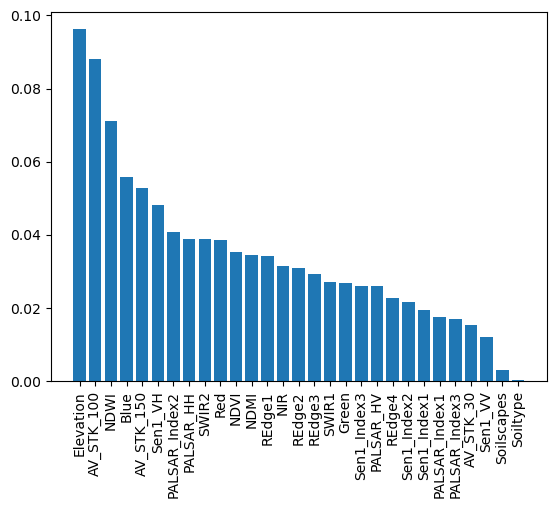

In [79]:
# get the importances and sort them
import operator
importances = trainedClassifier.explain().getInfo()['importance']
sorted_importances = sorted(importances.items(), key=operator.itemgetter(1), reverse=True)

# get the names and importances
predictor_names = list(zip(*sorted_importances))[0]
importances = list(zip(*sorted_importances))[1]

# normalise the importances 
norm_importances = [float(importance)/sum(importances) for importance in importances]

# plot the result
plt.bar(predictor_names, norm_importances);
plt.xticks(rotation=90);

In [80]:
# use the trained model to make predictions for training and test points
trainPredictions = trainingSet.classify(trainedClassifier, 'predicted depth')
testPredictions = testingSet.classify(trainedClassifier, 'predicted depth')

### 5. Assess model accuracy

Plot a histogram of training GT depths and a histogram of corresponding predictions

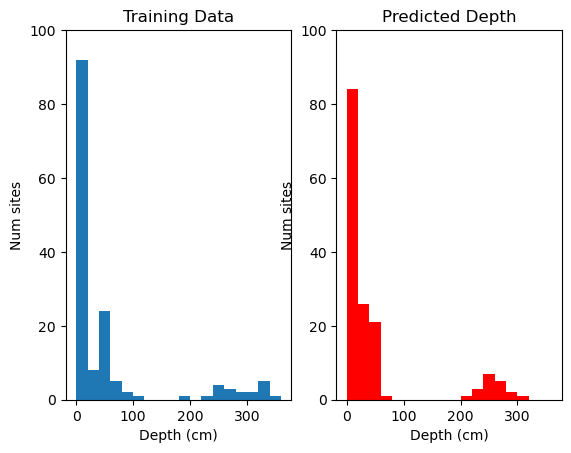

In [81]:
# get the relevant data
actual_depths = trainPredictions.aggregate_array('depth').getInfo()
predicted_depths = trainPredictions.aggregate_array('predicted depth').getInfo()

# plot the GT histogram
plt.subplot(1,2,1)
plt.hist(actual_depths, bins=18, range=(0,360));
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Training Data");
ax = plt.gca()
ax.set_ylim([0, 100]);

# plot the prediction histogram
plt.subplot(1,2,2)
plt.hist(predicted_depths, bins=18, range=(0,360), color='red');
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Predicted Depth");
ax = plt.gca()
ax.set_ylim([0, 100]);

Plot a scatter plot of the labels vs the predictions for the training data. If the accurate was 100% accurate then we would expect all the data points to line of the y=x curve

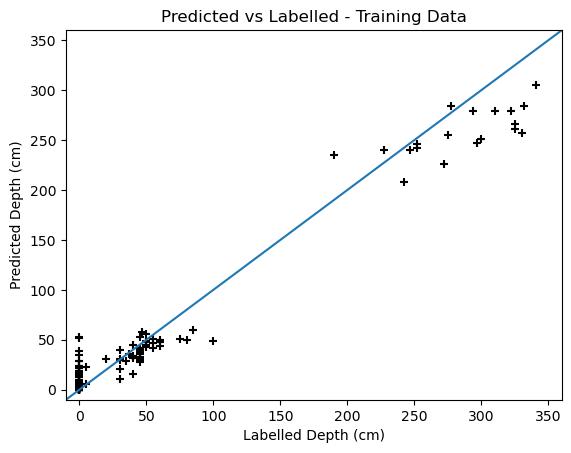

In [82]:
# add a scatter plot of the data points
plt.scatter(actual_depths, predicted_depths, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 360]);
ax.set_xlim([-10, 360]);

# add a y=x line
plt.plot([-10, 360], [-10, 360]);

In [83]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(actual_depths, predicted_depths)
print("R Squared:", R_squared)

RMSE = mean_squared_error(actual_depths, predicted_depths, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9580725613165516
RMSE: 19.12075479679775


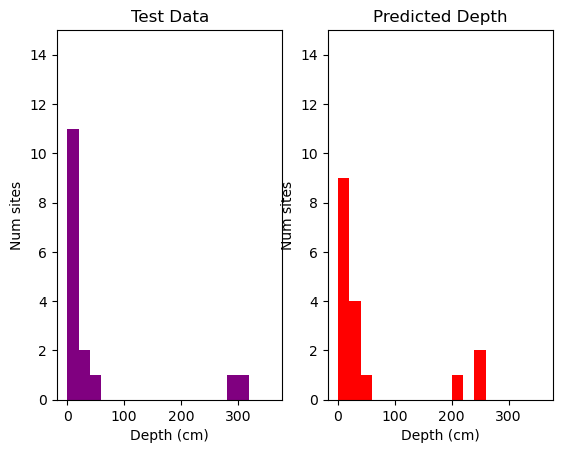

In [84]:
# get the relevant data
actual_depths = testPredictions.aggregate_array('depth').getInfo()
predicted_depths = testPredictions.aggregate_array('predicted depth').getInfo()

# plot the GT histogram
plt.subplot(1,2,1)
plt.hist(actual_depths, bins=18, range=(0,360), color='purple');
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Test Data");
ax = plt.gca()
ax.set_ylim([0, 15]);

# plot the prediction histogram
plt.subplot(1,2,2)
plt.hist(predicted_depths, bins=18, range=(0,360), color='red');
plt.xlabel("Depth (cm)")
plt.ylabel("Num sites")
plt.title("Predicted Depth");
ax = plt.gca()
ax.set_ylim([0, 15]);

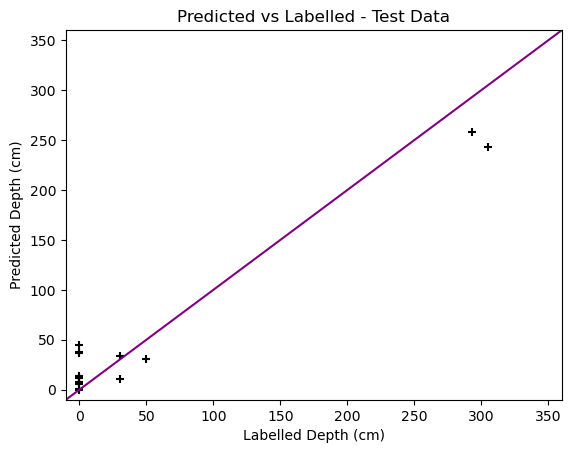

In [85]:
# add a scatter plot of the data points
plt.scatter(actual_depths, predicted_depths, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 360]);
ax.set_xlim([-10, 360]);

# add a y=x line
plt.plot([-10, 360], [-10, 360], c='purple');

In [86]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(actual_depths, predicted_depths)
print("R Squared:", R_squared)

RMSE = mean_squared_error(actual_depths, predicted_depths, squared=False)
print("RMSE:", RMSE)

R Squared: 0.8401077837052394
RMSE: 49.86362905416114


### 6. Predict across Fens

In [61]:
# clip the predictors to only that within the Fens boundary (should be redundant)
clipped_preds = predictor_stack.clip(fenOutline)

In [ ]:
# make predictions across the Fens using the predictors
classified_result = clipped_preds.classify(trainedClassifier, 'prediction')

In [ ]:
# find the minimum prediction value
#predictedMin = classified_result.reduceRegion(reducer=ee.Reducer.min(), geometry=fenOutline, scale=10, bestEffort=True)
#minVal = predictedMin.getNumber('prediction').getInfo()
#print("Minimum:", minVal)

# find the maximum prediction value
#predictedMax = classified_result.reduceRegion(reducer=ee.Reducer.max(), geometry=fenOutline, scale=10, bestEffort=True)
#maxVal = predictedMax.getNumber('prediction').getInfo()
#print("Maximum", maxVal)

In [ ]:
# plot the predictions: black = 0cm, red = 302cm
Map = geemap.Map()
visParams = {
    'palette': ['030303', 'd11515'],
    'max': 300,
    'min': 0,
}
Map.centerObject(fenOutline, 8)
Map.addLayer(classified_result, visParams, 'Peat depth predictions')
Map